<a href="https://colab.research.google.com/github/Syed-Raza-Ali/Browsing_AI_Agent/blob/main/Browsing_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# install the required packages
%%capture --no-stderr
%pip install -U tavily-python langchain_core langchain_google_genai tavily-python langchain_community langgraph python-dotenv

In [ ]:
!pip install -q langchain-core langchain-google-genai langgraph python-dotenv

In [53]:
# API KEYS VARIABLES
import os
from google.colab import userdata

os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
GOOGLE_API_KEY = userdata.get("GEMINI_API_KEY")


In [59]:
from langchain_community.tools.tavily_search import TavilySearchResults


# Initialize Tavily search tool
tavily_search = TavilySearchResults(max_results = 3)

# Maintain chat history
chat_history = []

def stream_graph_updates(user_input):
    """A placeholder function for processing graph updates."""
    print(f"Processing graph updates for: {user_input}")


print("Hello there! I am an browsing AI agent. Please give me a prompt, and I will bring you the answer by searching on Google")
print("Type 'exit' , 'quit' , 'q' , 'bye' for ending")


def main():
  """ Get realtime information using tavily search """

  while True:


    try:
        # Prompt the user for input
        print("\n")
        user_input = input("User : ").strip()

        # Exit condition
        if user_input.lower() in ["quit", "exit", "q","bye"]:
            print("Bye! Have a great day!")
            break

        # Handle empty input
        if not user_input:
            print("No prompt found. Please type something.")
            continue

        # Add user input to chat history
        chat_history.append({"role": "user", "content": user_input})

        # Call the placeholder function (replace as needed)
        try:
            stream_graph_updates(user_input)
        except NameError:
            # Handle missing function gracefully
            print("stream_graph_updates is not implemented. Skipping.")

        # Perform a Tavily search if the function is not implemented
        search_docs = tavily_search.invoke(user_input)

        # Add Tavily response to chat history
        chat_history.append({"role": "assistant", "content": str(search_docs)})

        # Display results from Tavily search
        print("Search Results:")
        for i, doc in enumerate(search_docs, start=1):
            print(f"\nResult {i}:")
            print(f"Here is the {i} documentaion from web search you can get your answer from here:")
            print(f"Documentation: {doc.get('content', 'N/A')}")
            print(f"URL: {doc.get('url', 'N/A')}")

    except Exception as e:
        print(f"An error occurred: {e}")
        break

    print("\nChat History:")
    for message in chat_history:
      role = message["role"]
      content = message["content"]
      print(f"{role.capitalize()}: {content}")



main()

Hello there! I am an browsing AI agent. Please give me a prompt, and I will bring you the answer by searching on Google
Type 'exit' , 'quit' , 'q' , 'bye' for ending


User : hey can you tell me today date
Processing graph updates for: hey can you tell me today date
Search Results:

Result 1:
Here is the 1 documentaion from web search you can get your answer from here:
Documentation: Check out today's date and current time at your location and anywhere in the World. Today's date. Wednesday, December 25, 2024. Today is the day number 360 of the year, in the #52 week of the year 2024. Only 5 days left for 2025! Current time: 17:23. December 2024 calendar.
URL: https://todays-date.net/

Result 2:
Here is the 2 documentaion from web search you can get your answer from here:
Documentation: The current date in British Date Format (DD-MM-YYYY) with two-digit day, separator, two-digit month, separator, four-digit year is:
The current date in American Date Format (MM-DD-YYYY) with two-digit mon

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

def main_two():
  """ Get realtime information using tavily search """
# Initialize Tavily search tool
  tavily_search = TavilySearchResults(max_results = 3)

# Maintain chat history
  chat_history = []

  print("Hello there! I am an browsing AI agent. Please give me a prompt, and I will bring you the answer by searching on Google")
  print("Type 'exit' , 'quit' , 'q' , 'bye' for ending")

  while True:

    try:
        # Prompt the user for input
        print("\n")
        user_input = input("User : ").strip()

        # Exit condition
        if user_input.lower() in ["quit", "exit", "q","bye"]:
            print("Bye! Have a great day!")
            break

        # Handle empty input
        if not user_input:
            print("No prompt found. Please type something.")
            continue

        # Add user input to chat history
        chat_history.append({"role": "user", "content": user_input})

        # Perform a Tavily search if the function is not implemented
        search_docs = tavily_search.invoke(user_input)

        # Add Tavily response to chat history
        chat_history.append({"role": "assistant", "content": str(search_docs)})

        # Display results from Tavily search
        print("Search Results:")
        for i, doc in enumerate(search_docs, start=1):
            print(f"\nResult {i}:")
            print(f"Here is the {i} documentaion from web search you can get your answer from here:")
            print(f"Documentation: {doc.get('content', 'N/A')}")
            print(f"URL: {doc.get('url', 'N/A')}")

    except Exception as e:
        print(f"An error occurred: {e}")
        break

    print("\nChat History:")
    for message in chat_history:
      role = message["role"]
      content = message["content"]
      print(f"{role.capitalize()}: {content}")



# main_two()

In [28]:
#llm with tools
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key = GOOGLE_API_KEY
)
tool = [main_two, main]

llm_with_tools = llm.bind_tools(tool)

In [36]:
import os
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from google.colab import userdata


GOOGLE_API_KEY = userdata.get("GEMINI_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY


# Disable LangSmith Tracing programmatically
langchain_api_key = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "Health-Agent"

# Initialize the Gemini LLM model with Google API Key


from langchain_community.tools.tavily_search import TavilySearchResults

def main_two():
  """ Get realtime information using tavily search """
# Initialize Tavily search tool
  tavily_search = TavilySearchResults(max_results = 1)

# Maintain chat history
  chat_history = []

  print("Hello there! I am an browsing AI agent. Please give me a prompt, and I will bring you the answer by searching on Google")
  print("Type 'exit' , 'quit' , 'q' , 'bye' for ending")

  while True:

    try:
        # Prompt the user for input
        print("\n")
        user_input = input("User : ").strip()

        # Exit condition
        if user_input.lower() in ["quit", "exit", "q","bye"]:
            print("Bye! Have a great day!")
            break

        # Handle empty input
        if not user_input:
            print("No prompt found. Please type something.")
            continue

        # Add user input to chat history
        chat_history.append({"role": "user", "content": user_input})

        # Perform a Tavily search if the function is not implemented
        search_docs = tavily_search.invoke(user_input)

        # Add Tavily response to chat history
        chat_history.append({"role": "assistant", "content": str(search_docs)})

        # Display results from Tavily search
        print("Search Results:")
        for i, doc in enumerate(search_docs, start=1):
            print(f"\nResult {i}:")
            print(f"Here is the {i} documentaion from web search you can get your answer from here:")
            print(f"Documentation: {doc.get('content', 'N/A')}")
            print(f"URL: {doc.get('url', 'N/A')}")

    except Exception as e:
        print(f"An error occurred: {e}")
        break

    print("\nChat History:")
    for message in chat_history:
      role = message["role"]
      content = message["content"]
      print(f"{role.capitalize()}: {content}")



# main_two()


# LangGraph nodes
def model_conversation(state: MessagesState):
    """Core conversational logic."""
    system_message = "you are a browsing ai assistant you have a tool name main_two which is for tavily search when ever user asked something you have to search using tool and then make enahce tavily responce then give anser to user"
    messages = [SystemMessage(content=system_message)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": response}
tool_node = ToolNode(tools=tool)
# workflow.add_node("tools", tool_node)

# Define the workflow
workflow = StateGraph(MessagesState)
# workflow.add_node("conversation", model_conversation)
# workflow.add_node("tools", tool_node)


workflow.add_node("conversation", model_conversation)
workflow.add_node("tavily", main_two)
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", main_two)
workflow.add_edge("tavily", END)
# Define conditional edges for the chatbot node based on tool usage
# workflow.add_conditional_edges(
#     "conversation",
#     tools_condition
# )

# # Any time a tool is called, we return to the chatbot to decide the next step
# workflow.add_edge("tools", "conversation")

# # Define the starting point of the graph as the chatbot node
# workflow.add_edge(START, "conversation")

# Compile the graph with memory
# memory = MemorySaver()
graph = workflow.compile()


# Chatbot runtime logic
def agent_calling():
    """ Run the agent."""
    config = {"configurable": {"thread_id": "1"}}

    while True:
        user_input = input("You: ")

        if user_input.lower() in ["exit", "bye", "quit", "q" ]:
            print("Goodbye! Thank you for your trust, I hope this information is helpful for you")
            break


        input_message = HumanMessage(content=user_input)
        output = graph.invoke({"messages": [input_message]}, config)

        # try:
        #     output = graph.invoke({"messages": [input_message]}, config)
        # except Exception as e:
        #     print(f"Error: {str(e)}")
        #     continue

        bot_response = output["messages"][-1].content
        print(f"Chatbot: {bot_response}")

        state = graph.get_state(config)



# Run the chatbot
agent_calling()



You: who is the prime minister of US in 2020


TypeError: main_two() takes 0 positional arguments but 1 was given

In [51]:
import os
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from google.colab import userdata


GOOGLE_API_KEY = userdata.get("GEMINI_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY


# Disable LangSmith Tracing programmatically
langchain_api_key = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "Health-Agent"

# Initialize the Gemini LLM model with Google API Key


from langchain_community.tools.tavily_search import TavilySearchResults

def main_two(state=None):
    """Get real-time information using Tavily search."""
    # Initialize Tavily search tool
    tavily_search = TavilySearchResults(max_results=1)

    # # Maintain chat history
    # chat_history = []

    # print("Hello there! I am a browsing AI agent. Please give me a prompt, and I will bring you the answer by searching on Google.")
    # print("Type 'exit', 'quit', 'q', or 'bye' to end.")

    while True:
        try:
            # Prompt the user for input
            print("\n")
            user_input = input("User : ").strip()

            # Exit condition
            if user_input.lower() in ["quit", "exit", "q", "bye"]:
                print("Bye! Have a great day!")
                break

            # Handle empty input
            if not user_input:
                print("No prompt found. Please type something.")
                continue

            # Add user input to chat history
            chat_history.append({"role": "user", "content": user_input})

            # Perform a Tavily search
            search_docs = tavily_search.invoke(user_input)

            # Add Tavily response to chat history
            chat_history.append({"role": "assistant", "content": str(search_docs)})

            # Display results from Tavily search
            print("Search Results:")
            for i, doc in enumerate(search_docs, start=1):
                print(f"\nResult {i}:")
                print(f"Here is the {i} documentation from the web search you can get your answer from here:")
                print(f"Documentation: {doc.get('content', 'N/A')}")
                print(f"URL: {doc.get('url', 'N/A')}")

        except Exception as e:
            print(f"An error occurred: {e}")
            break

        # print("\nChat History:")
        # for message in chat_history:
        #     role = message["role"]
        #     content = message["content"]
        #     print(f"{role.capitalize()}: {content}")



# LangGraph nodes
def model_conversation(state: MessagesState):
    """Core conversational logic."""
    system_message = "Whenever a user provides a prompt, respond to them by conducting real-time searching."
    messages = [SystemMessage(content=system_message)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": response}
tool_node = ToolNode(tools=tool)
# workflow.add_node("tools", tool_node)

# Define the workflow
workflow = StateGraph(MessagesState)
# workflow.add_node("conversation", model_conversation)
workflow.add_node("tools", tool_node)


workflow.add_node("conversation", model_conversation)
# workflow.add_node("tavily", main_two)
workflow.add_edge(START, "conversation")
# workflow.add_conditional_edges("conversation", main_two)
# workflow.add_edge("tavily", END)
# Define conditional edges for the chatbot node based on tool usage
workflow.add_conditional_edges(
    "conversation",
    main_two
)

# # Any time a tool is called, we return to the chatbot to decide the next step
workflow.add_edge("tools", "conversation")

# # Define the starting point of the graph as the chatbot node
# workflow.add_edge(START, "conversation")

# Compile the graph with memory
# memory = MemorySaver()
graph = workflow.compile()


# Chatbot runtime logic
def agent_calling():
    """ Run the agent."""
    config = {"configurable": {"thread_id": "1"}}

    while True:
        user_input = input("You: ")

        if user_input.lower() in ["exit", "bye", "quit", "q" ]:
            print("Goodbye! Thank you for your trust, I hope this information is helpful for you")
            break


        input_message = HumanMessage(content=user_input)
        output = graph.invoke({"messages": [input_message]}, config)

        # try:
        #     output = graph.invoke({"messages": [input_message]}, config)
        # except Exception as e:
        #     print(f"Error: {str(e)}")
        #     continue

        bot_response = output["messages"][-1].content
        print(f"Chatbot: {bot_response}")

        state = graph.get_state(config)



# Run the chatbot
agent_calling()



You: who is the  prime minister of US in 2024


User : who is the prime minister of us in 2024
Search Results:

Result 1:
Here is the 1 documentation from the web search you can get your answer from here:
Documentation: Contact us; Contribute Help; Learn to edit; Community portal; Recent changes; Upload file; Search. Search. ... Prime Minister of Libya (Government of National Unity) Provisional government: 15 March 2021 ... 27 May 2024 211 days Judith Tuluka: Prime Minister of the Democratic Republic of the Congo: Semi-presidential republic 12 June 2024
URL: https://en.wikipedia.org/wiki/List_of_current_prime_ministers_by_date_of_assumption_of_office


User : exit
Bye! Have a great day!


ValueError: Branch did not return a valid destination

In [57]:
import os
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
# from langchain.llms import LLMNode
from langchain_community.tools.tavily_search import TavilySearchResults

def main_two(state=None):
  """
  Performs real-time information retrieval using Tavily search
  and feeds the results back to the LLM for further processing.
  """
  # Initialize Tavily search tool
  tavily_search = TavilySearchResults(max_results=1)

  # Prompt the user for input
  user_input = input("User: ").strip()

  # Exit condition
  if user_input.lower() in ["quit", "exit", "q", "bye"]:
    return {"message": "Bye! Have a great day!"}

  # Handle empty input
  if not user_input:
    return {"message": "No prompt found. Please type something."}

  # Perform a Tavily search
  search_docs = tavily_search.invoke(user_input)

  # Prepare data for LLM
  data = {
      "prompt": user_input,
      "tavily_results": search_docs
  }

  # Forward data to LLM for processing (replace with your LLM integration)
  llm_response = llm_with_tools.invoke(data)

  return {"message": llm_response}

# LangChain nodes
def conversation(state: MessagesState):
  """
  Core conversational logic.
  - Forwards user prompt to Tavily for real-time search.
  - Sends search results along with the prompt to the LLM for processing.
  - Returns the LLM generated response.
  """
  user_input = state["message"]
  response = main_two(user_input)
  return {"messages": [SystemMessage(content=response["message"])]}

# Define the workflow
workflow = StateGraph(MessagesState)
workflow.add_node("conversation", conversation)
workflow.add_edge(START, "conversation")
workflow.add_edge("conversation", END)

# Compile the graph
graph = workflow.compile()

# Chatbot runtime logic
def agent_calling():
  """
  Runs the conversational agent.
  """
  while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "bye", "quit", "q"]:
      print("Goodbye! Thank you for your trust, I hope this information is helpful for you")
      break

    output = graph.invoke({"message": user_input})
    bot_response = output["messages"][0].content
    print(f"Chatbot: {bot_response}")

# Replace with your LLM integration (assuming llm_with_tools is the LLM node)
# llm_with_tools = llm.bind_tools(tool_name=main_two)  # Replace with your LLM tool name

# Run the chatbot
agent_calling()

You: who is the prime minister of US in 2024


InvalidUpdateError: Must write to at least one of ['messages']

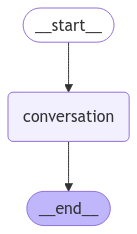

In [58]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass